In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#from simpledbf import Dbf5
import datetime as date 

In [2]:
dbfpath = './datasets/taxi_zones.dbf'
data = Dbf5(dbfpath).to_dataframe()
data

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough
0,1,0.116357,0.000782,Newark Airport,1,EWR
1,2,0.433470,0.004866,Jamaica Bay,2,Queens
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx
3,4,0.043567,0.000112,Alphabet City,4,Manhattan
4,5,0.092146,0.000498,Arden Heights,5,Staten Island
...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx
259,260,0.133514,0.000422,Woodside,260,Queens
260,261,0.027120,0.000034,World Trade Center,261,Manhattan
261,262,0.049064,0.000122,Yorkville East,262,Manhattan


In [3]:
def get_missings(df,plot=True,rotation=45,figsize=(10,5),**kwargs):
    labels,values,percent = list(),list(),list()
    if df.isna().sum().sum():
        for column in df.columns:
            if df[column].isna().sum():
                labels.append(column)
                values.append(df[column].isna().sum())
                percent.append((df[column].isna().sum() / df.shape[0])*100)
        #Make a dataframe 
        missings=pd.DataFrame({'Features':labels,'MissingValues':values,'MissingPercent':percent}).sort_values(by='MissingPercent',ascending=False)

        if plot:
            plt.figure(figsize=figsize)
            sns.barplot(x=missings.Features,y=missings.MissingPercent).set_title('The Percentage of Missing Values',size=22)
            locs, labels = plt.xticks()
            plt.setp(labels, rotation=rotation,size=16)
            plt.xlabel('Features',size=18)
            plt.ylabel('MissingPercent',size=18)

        return missings
    else:
        return False

In [4]:
#funcion para calcular outliers
def outliers_obt(data, columna,valoriqr=1.5):
    ##calculamos los cuartiles 
    Q1 = data[columna].quantile(0.25)
    #print('Primer Cuartile', Q1)
    Q3 = data[columna].quantile(0.75)
    #print('Tercer Cuartile',Q3)
    IQR = Q3 - Q1
    #print('Rango intercuartile', IQR)

    ##calculamos los bigotes superior e inferior
    BI = (Q1 - valoriqr * IQR)
    #print('bigote Inferior \n', BI)
    BS = (Q3 + valoriqr * IQR)
    #print('bigote superior \n', BS)

    ##obtenemos una nueva tabla sin los outliers
    ubi_sin_out = data[(data[columna] >= BI) & (data[columna] <= BS)]
    return ubi_sin_out

In [5]:
df = pd.read_parquet('datasets/yellow_tripdata_2018-01.parquet')
df.head(2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,1,N,41,24,2,4.5,0.5,0.5,0.0,0.0,0.3,5.8,NaN,NaN
1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,1,N,239,140,2,14.0,0.5,0.5,0.0,0.0,0.3,15.3,NaN,NaN


In [6]:
df_notnull = pd.DataFrame(df.notnull().sum())
df_notnull = df_notnull.rename_axis("Atributo").reset_index()
df_notnull.columns = ["Atributo","Not null"]
df_null = pd.DataFrame(df.isnull().sum())
df_null = df_null.rename_axis("Atributo").reset_index()
df_null.columns = ["Atributo","Null"]
df_total = df_notnull.merge(df_null)

df_total

,Atributo,Not null,Null
0,VendorID,8760687,0
1,tpep_pickup_datetime,8760687,0
2,tpep_dropoff_datetime,8760687,0
3,passenger_count,8760687,0
4,trip_distance,8760687,0
5,RatecodeID,8760687,0
6,store_and_fwd_flag,8760687,0
7,PULocationID,8760687,0
8,DOLocationID,8760687,0
9,payment_type,8760687,0


## Informe preliminar de taxis de NYC

<p>Lo que vamos a realizar es una simple visualizacion de los tipos de datos, valores nulos y atipicos(outliers) <p>

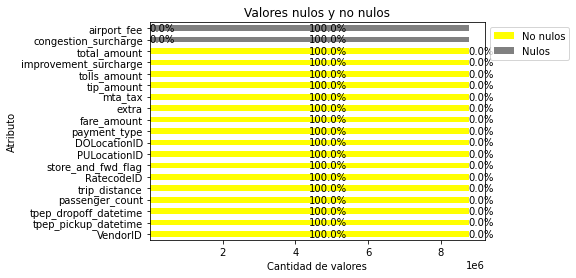

In [7]:
df_total.plot( 
    x = 'Atributo', 
    kind = 'barh', 
    stacked = True, 
    title = 'Valores nulos y no nulos', 
    mark_right = False,
    color=["yellow","gray"])
plt.xlabel('Cantidad de valores')
plt.legend(labels = ['No nulos','Nulos'],loc = 0, bbox_to_anchor = (1,1))

df_totales = df_total["Not null"] + df_total["Null"]
df_rel =df_total[df_total.columns[1:]].div(df_totales, 0)*100

for n in df_rel: 
    for i,(cs, ab, pc) in enumerate(zip(df_total.iloc[:, 1:].cumsum(1)[n],
                                         df_total[n], df_rel[n])): 
        plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%',
                 va = 'center', ha = 'left')

#### Con los valores nulos de las columnas congestion_surcharge y airport_fee la normalizaremos

## Visualizacion de outliers

### Monto total cobrado a los pasajeros

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


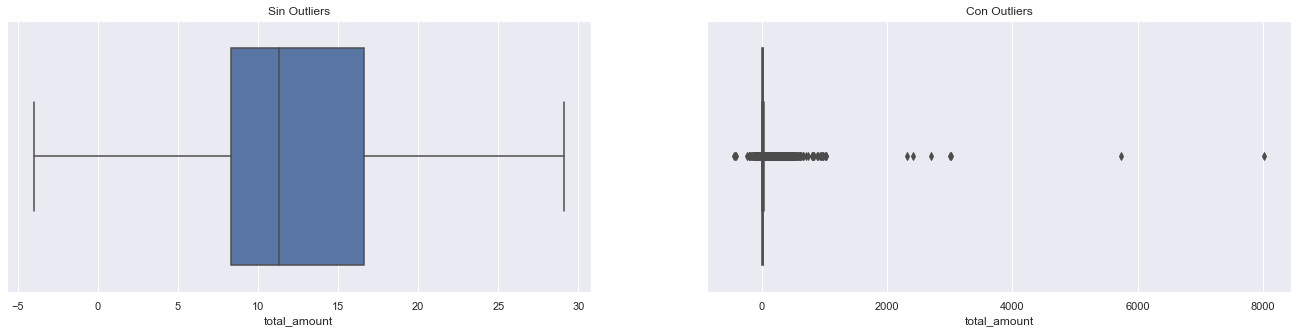

In [8]:
sns.set(rc = {'figure.figsize':(23,5)})
f, ax = plt.subplots(1,2)
sns.boxplot(df.total_amount, showfliers = False, ax=ax[0]).set_title('Sin Outliers')
sns.boxplot(df.total_amount, ax=ax[1]).set_title('Con Outliers')
plt.show()


In [9]:
(df.tolls_amount.value_counts(normalize=True) * 100)

0.00      95.149433
5.76       4.470266
10.50      0.068693
2.64       0.044175
12.50      0.043558
            ...    
11.30      0.000011
550.09     0.000011
18.41      0.000011
5.12       0.000011
7.30       0.000011
Name: tolls_amount, Length: 967, dtype: float64

## Reacargo por mejora evaluados en los viajes por el descenso de bandera

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


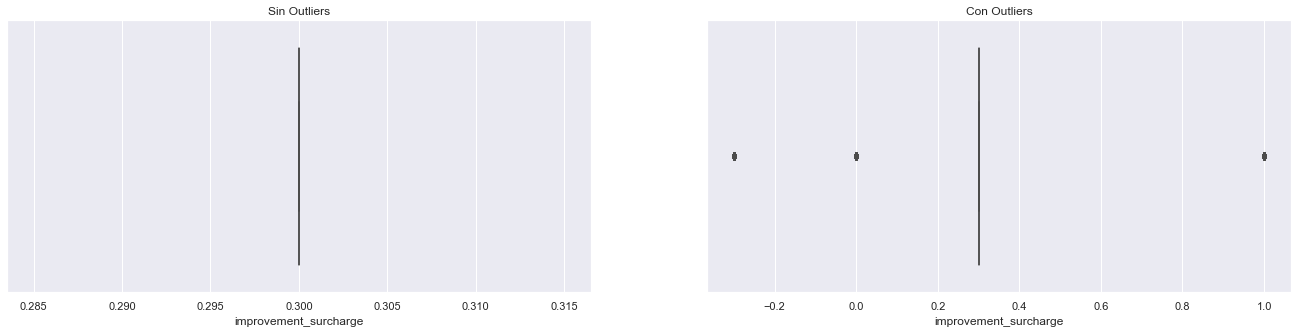

In [10]:
f, ax = plt.subplots(1,2)
sns.boxplot(df.improvement_surcharge, showfliers = False, ax=ax[0]).set_title('Sin Outliers')
sns.boxplot(df.improvement_surcharge, ax=ax[1]).set_title('Con Outliers')
plt.show()

hay un 95% de recargos no cobrados

## Importe de todos los peajes

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


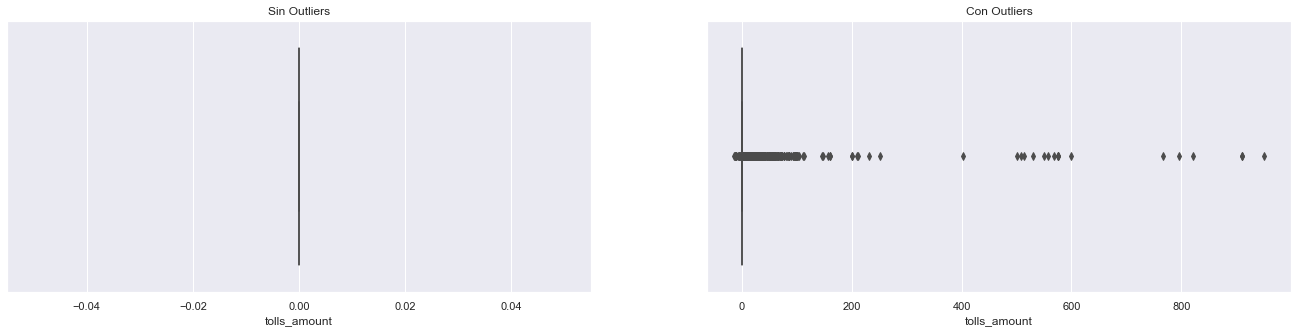

In [11]:
f, ax = plt.subplots(1,2)
sns.boxplot(df.tolls_amount, showfliers = False, ax=ax[0]).set_title('Sin Outliers')
sns.boxplot(df.tolls_amount, ax=ax[1]).set_title('Con Outliers')
plt.show()

In [12]:
(df.tolls_amount.value_counts(normalize=True) * 100)


0.00      95.149433
5.76       4.470266
10.50      0.068693
2.64       0.044175
12.50      0.043558
            ...    
11.30      0.000011
550.09     0.000011
18.41      0.000011
5.12       0.000011
7.30       0.000011
Name: tolls_amount, Length: 967, dtype: float64

## monto por propina

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


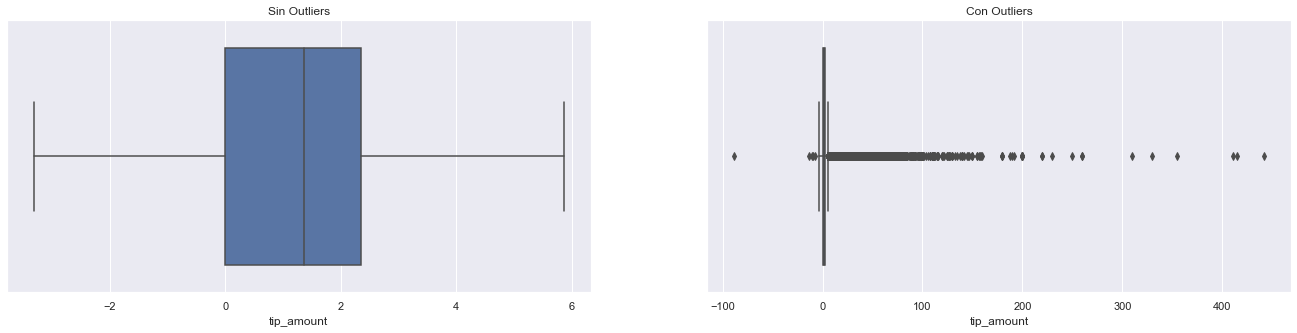

In [13]:
f, ax = plt.subplots(1,2)
sns.boxplot(df.tip_amount, showfliers = False, ax=ax[0]).set_title('Sin Outliers')
sns.boxplot(df.tip_amount, ax=ax[1]).set_title('Con Outliers')
plt.show()

## Impuestos MTA

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 936x576 with 0 Axes>

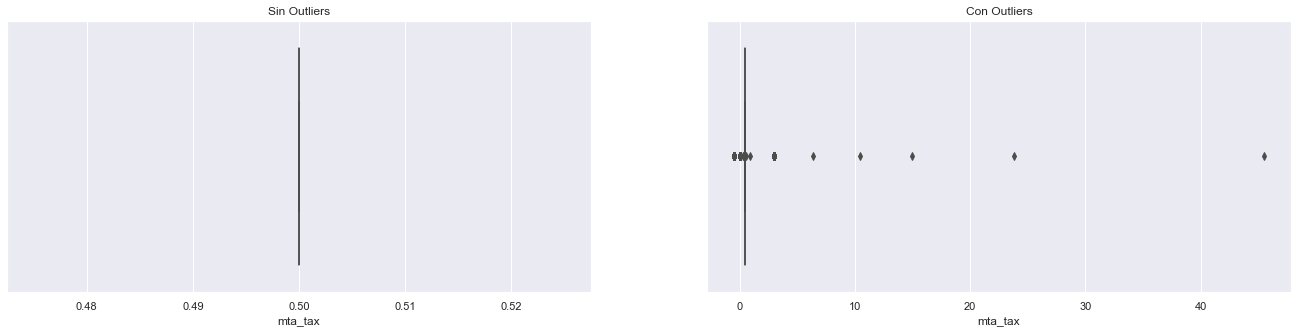

In [14]:
plt.figure(figsize=(13,8))
f, ax = plt.subplots(1,2)
sns.boxplot(df.mta_tax, showfliers = False, ax=ax[0]).set_title('Sin Outliers')
sns.boxplot(df.mta_tax, ax=ax[1]).set_title('Con Outliers')
plt.show()

In [15]:
(df.mta_tax.value_counts(normalize=True) * 100)

 0.50     99.541337
 0.00      0.410219
-0.50      0.047405
 3.00      0.000833
 0.01      0.000057
 0.35      0.000046
 0.90      0.000011
 0.40      0.000011
 6.33      0.000011
 15.00     0.000011
 0.32      0.000011
 23.80     0.000011
 45.49     0.000011
 10.41     0.000011
 0.60      0.000011
Name: mta_tax, dtype: float64

## Recargos Extras

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


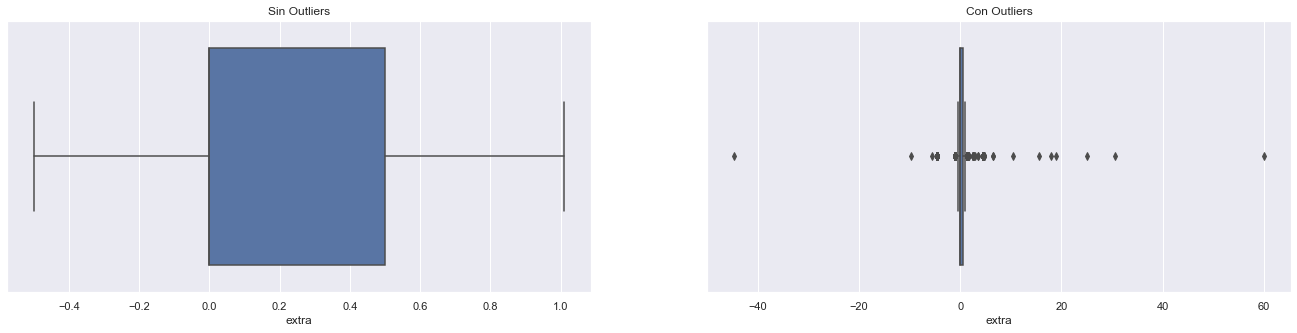

In [16]:
f, ax = plt.subplots(1,2)
sns.boxplot(df.extra, showfliers = False, ax=ax[0]).set_title('Sin Outliers')
sns.boxplot(df.extra, ax=ax[1]).set_title('Con Outliers')
plt.show()

## Tarifa de tiempo

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


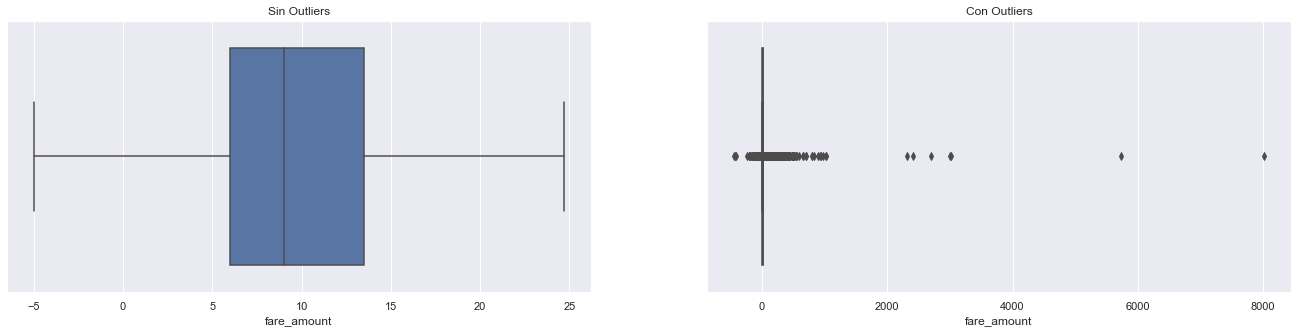

In [17]:
f, ax = plt.subplots(1,2)
sns.boxplot(df.fare_amount, showfliers = False, ax=ax[0]).set_title('Sin Outliers')
sns.boxplot(df.fare_amount, ax=ax[1]).set_title('Con Outliers')
plt.show()

## Distancia en millas 

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


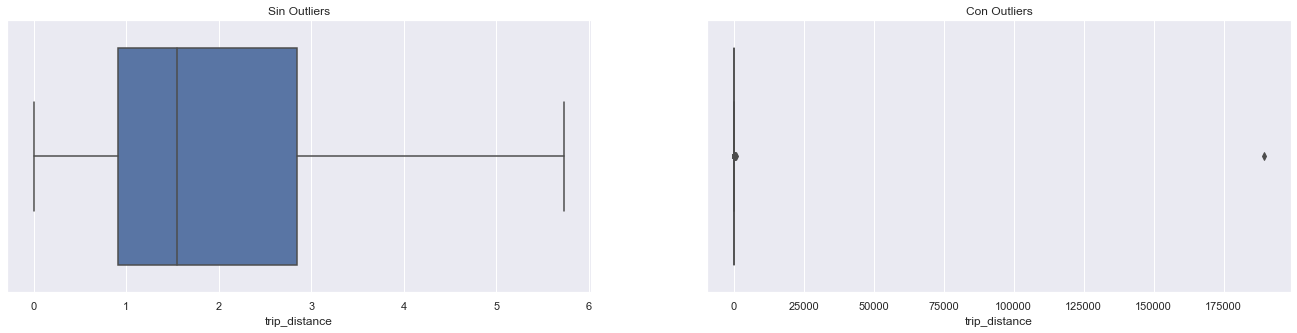

In [18]:
f, ax = plt.subplots(1,2)
sns.boxplot(df.trip_distance, showfliers = False, ax=ax[0]).set_title('Sin Outliers')
sns.boxplot(df.trip_distance, ax=ax[1]).set_title('Con Outliers')
plt.show()

# Conclusion:
`Columnas con valores nulos congestion_surcharge, airport_fee se eliminaran dichas columnas ya que son casi 100% de registros nulos`

`Las columnas con valores atipicos son las siguientes: trip_distance, trip_distance, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount`
 
`los valores extremos de las columnas trip_distance, fare_amount, mta_tax y total_amount se los podria eliminar`




In [1]:
df.tail(10)

NameError: name 'df' is not defined

Creo una copia de df de taxis

In [20]:
df_changes =df

le agrego 0 a las filas nulas de congestion_surcharge y airport_fee 

In [21]:
df_changes['congestion_surcharge'].fillna(0.0, inplace=True)
df_changes['airport_fee'].fillna(0.0, inplace=True)

creo una nueva columna del monto total restando las posibles columnas que no vamos a usar 

In [22]:
df_changes['total_amount_1'] = df_changes.total_amount - df_changes.tolls_amount - df_changes.congestion_surcharge - df_changes.airport_fee

In [23]:
df_changes.drop(['congestion_surcharge','airport_fee'], axis=1, inplace=True)

creo nueva columna del tiempo de vieja desde que sube al taxis hasta que baja

In [24]:
df_changes['Travel_time'] = df_changes.tpep_dropoff_datetime - df_changes.tpep_pickup_datetime


In [25]:
df_changes.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
total_amount_1           0
Travel_time              0
dtype: int64

columna creada para realiar un merge con los borough

In [26]:
df_changes['LocationID']=df_changes['PULocationID']

columnas de dias y horas

In [27]:
df_changes['day'] = df_changes['tpep_pickup_datetime'].map(lambda x: x.weekday()+1)
df_changes['hour'] = df_changes['tpep_pickup_datetime'].map(lambda x: x.hour)
conditionlist = [
    (df_changes['hour']<6),
    (df_changes['hour']<13),
    (df_changes['hour']<19),
    (df_changes['hour']<24)]
turnos = ['late_night', 'morning', 'afternoon', 'night']
df_changes['turno'] = np.select(conditionlist, turnos, default='Not Specified')

levanto la tabla de los borough

In [91]:
df_Taxi_zone = pd.read_csv('./datasets/taxi+_zone_lookup.csv')

In [29]:
df_Taxi_zone['Zone'].fillna('Not specified',inplace=True)
df_Taxi_zone['service_zone'].fillna('Not specified',inplace=True)

realizo el merge

In [30]:
df_changes= df_changes.merge(df_Taxi_zone, how='left', on='LocationID')

nose si sirva pero ahi esta una tabla con las columnas que creo importante, quiza falten algunas mas para realizar los calculos

In [31]:
df_costos = df_changes[['LocationID','Borough','Zone','trip_distance','total_amount_1','payment_type','Travel_time','hour','day','turno']]
df_costos

,LocationID,Borough,Zone,trip_distance,total_amount_1,payment_type,Travel_time,hour,day,turno
0,41,Manhattan,Central Harlem,0.50,5.80,2,0 days 00:03:18,0,1,late_night
1,239,Manhattan,Upper West Side South,2.70,15.30,2,0 days 00:18:10,0,1,late_night
2,262,Manhattan,Yorkville East,0.80,8.30,1,0 days 00:05:55,0,1,late_night
3,140,Manhattan,Lenox Hill East,10.20,34.80,2,0 days 00:32:29,0,1,late_night
4,246,Manhattan,West Chelsea/Hudson Yards,2.50,16.55,1,0 days 00:17:48,0,1,late_night
...,...,...,...,...,...,...,...,...,...,...
8760682,158,Manhattan,Meatpacking/West Village West,2.80,15.95,1,0 days 00:12:45,23,3,night
8760683,163,Manhattan,Midtown North,0.60,6.95,1,0 days 00:03:06,23,3,night
8760684,74,Manhattan,East Harlem North,2.95,11.80,2,0 days 00:09:09,23,3,night
8760685,7,Queens,Astoria,0.00,0.00,2,0 days 00:00:48,23,3,night


In [5]:
def calendar_table(start='', end=''):
    df = pd.DataFrame({'Date':pd.date_range(start, end)})
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['Week'] = df.Date.dt.isocalendar().week
    df['Weekday'] = df.Date.dt.day_of_week + 1
    return df

In [36]:
df_changes

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,total_amount,total_amount_1,Travel_time,LocationID,day,hour,turno,Borough,Zone,service_zone
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.50,1,N,41,24,2,...,5.80,5.80,0 days 00:03:18,41,1,0,late_night,Manhattan,Central Harlem,Boro Zone
1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.70,1,N,239,140,2,...,15.30,15.30,0 days 00:18:10,239,1,0,late_night,Manhattan,Upper West Side South,Yellow Zone
2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.80,1,N,262,141,1,...,8.30,8.30,0 days 00:05:55,262,1,0,late_night,Manhattan,Yorkville East,Yellow Zone
3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.20,1,N,140,257,2,...,34.80,34.80,0 days 00:32:29,140,1,0,late_night,Manhattan,Lenox Hill East,Yellow Zone
4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.50,1,N,246,239,1,...,16.55,16.55,0 days 00:17:48,246,1,0,late_night,Manhattan,West Chelsea/Hudson Yards,Yellow Zone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8760682,1,2018-01-31 23:21:35,2018-01-31 23:34:20,2,2.80,1,N,158,163,1,...,15.95,15.95,0 days 00:12:45,158,3,23,night,Manhattan,Meatpacking/West Village West,Yellow Zone
8760683,1,2018-01-31 23:35:51,2018-01-31 23:38:57,1,0.60,1,N,163,162,1,...,6.95,6.95,0 days 00:03:06,163,3,23,night,Manhattan,Midtown North,Yellow Zone
8760684,2,2018-01-31 23:28:00,2018-01-31 23:37:09,1,2.95,1,N,74,69,2,...,11.80,11.80,0 days 00:09:09,74,3,23,night,Manhattan,East Harlem North,Boro Zone
8760685,2,2018-01-31 23:24:40,2018-01-31 23:25:28,1,0.00,1,N,7,193,2,...,0.00,0.00,0 days 00:00:48,7,3,23,night,Queens,Astoria,Boro Zone


In [102]:
df_changes.rename(columns={ 'VendorID':'IdVendor','RatecodeID':'IdRatecode','PULocationID':'IdPULocation','DOLocationID':'IdDOLocation',
                            'payment_type':'IdPayment_type','LocationID':'IdLocation'},inplace=True)

In [104]:
df_changes.columns

Index(['IdTaxis_2018', 'IdVendor', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'IdRatecode', 'store_and_fwd_flag', 'IdPULocation', 'IdDOLocation',
       'IdPayment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'total_amount_1', 'Travel_time', 'IdLocation', 'day', 'hour', 'turno',
       'Borough', 'Zone', 'service_zone'],
      dtype='object')

In [105]:
taxi_trip_2018 = df_changes[[   'IdTaxis_2018','IdVendor','tpep_pickup_datetime','tpep_dropoff_datetime','Travel_time','IdRatecode','IdPULocation'
                                ,'IdDOLocation','IdPayment_type','fare_amount','extra','mta_tax','tip_amount','improvement_surcharge','total_amount_1']]

In [106]:
taxi_trip_2018

,IdTaxis_2018,IdVendor,tpep_pickup_datetime,tpep_dropoff_datetime,Travel_time,IdRatecode,IdPULocation,IdDOLocation,IdPayment_type,fare_amount,extra,mta_tax,tip_amount,improvement_surcharge,total_amount_1
0,0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,0 days 00:03:18,1,41,24,2,4.5,0.5,0.5,0.00,0.3,5.80
1,1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,0 days 00:18:10,1,239,140,2,14.0,0.5,0.5,0.00,0.3,15.30
2,2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,0 days 00:05:55,1,262,141,1,6.0,0.5,0.5,1.00,0.3,8.30
3,3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,0 days 00:32:29,1,140,257,2,33.5,0.5,0.5,0.00,0.3,34.80
4,4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,0 days 00:17:48,1,246,239,1,12.5,0.5,0.5,2.75,0.3,16.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8760682,8760682,1,2018-01-31 23:21:35,2018-01-31 23:34:20,0 days 00:12:45,1,158,163,1,12.0,0.5,0.5,2.65,0.3,15.95
8760683,8760683,1,2018-01-31 23:35:51,2018-01-31 23:38:57,0 days 00:03:06,1,163,162,1,4.5,0.5,0.5,1.15,0.3,6.95
8760684,8760684,2,2018-01-31 23:28:00,2018-01-31 23:37:09,0 days 00:09:09,1,74,69,2,10.5,0.5,0.5,0.00,0.3,11.80
8760685,8760685,2,2018-01-31 23:24:40,2018-01-31 23:25:28,0 days 00:00:48,1,7,193,2,0.0,0.0,0.0,0.00,0.0,0.00


In [37]:
vendor={    1:'Creative Mobile Technologies, LLC',
            2:'VeriFone Inc'}

df_vendor = pd.DataFrame([[key, vendor[key]] for key in vendor.keys()], columns=['IdVendor', 'Name_vendor'])

In [38]:
df_vendor

,IdVendor,Name_vendor
0,1,"Creative Mobile Technologies, LLC"
1,2,VeriFone Inc


1= Tarifa estándar, **2**= jfk, **3**= nuevaark, **4**= nassau o westchester, **5**= tarifa negociada, **6**= paseo en grupo

In [39]:
Ratecode={  1:'Tarifa estándar',
            2:'jfk',
            3:'nuevaark',
            4:'nassau o westchester',
            5:'tarifa negociada',
            6:'paseo en grupo'}

df_Ratecode = pd.DataFrame([[key, Ratecode[key]] for key in Ratecode.keys()], columns=['IdRatecode', 'Name_ratecode'])

In [41]:
df_Ratecode

,IdRatecode,Name_ratecode
0,1,Tarifa estándar
1,2,jfk
2,3,nuevaark
3,4,nassau o westchester
4,5,tarifa negociada
5,6,paseo en grupo


**1= tarjeta de crédito, **2**= efectivo, **3**= sin cargo, **4**= disputa, **5**= desconocido, **6**= viaje anulado**

In [43]:
payment={   1:'tarjeta de crédito',
            2:'efectivo',
            3:'sin cargo',
            4:'disputa',
            5:'desconocido',
            6:'viaje anulado'}

df_payment = pd.DataFrame([[key, payment[key]] for key in payment.keys()], columns=['IdPayment_type', 'Payment_type'])

In [44]:
df_payment

,IdPayment_type,Payment_type
0,1,tarjeta de crédito
1,2,efectivo
2,3,sin cargo
3,4,disputa
4,5,desconocido
5,6,viaje anulado


In [46]:
df_changes.reset_index(inplace=True)

In [49]:
df_changes.rename(columns={'index':'IdTaxis_2018'}, inplace=True)

In [59]:
Borough_dic = [ {'IdBorough':1,'Borough':'EWR','Latitude':40.6895314,'Longitude':-74.17446239999998},
                {'IdBorough':2,'Borough':'Queens','Latitude':40.742054,'Longitude':-73.769417},
                {'IdBorough':3,'Borough':'Bronx','Latitude':40.837048,'Longitude':-73.865433},
                {'IdBorough':4,'Borough':'Manhattan','Latitude':40.776676,'Longitude':-73.971321},
                {'IdBorough':4,'Borough':'Staten Island','Latitude':40.579021,'Longitude':-74.151535},
                {'IdBorough':6,'Borough':'Brooklyn','Latitude':40.650002,'Longitude':-73.949997}]

In [61]:
Borough = pd.DataFrame(Borough_dic)

In [64]:
Borough

,IdBorough,Borough,Latitude,Longitude
0,1,EWR,40.689531,-74.174462
1,2,Queens,40.742054,-73.769417
2,3,Bronx,40.837048,-73.865433
3,4,Manhattan,40.776676,-73.971321
4,4,Staten Island,40.579021,-74.151535
5,6,Brooklyn,40.650002,-73.949997


In [93]:
def algo(params):
    try:
        return Borough.IdBorough[Borough.Borough== params].iloc[0]
    except:
        return 7

In [94]:
df_Taxi_zone.Borough = df_Taxi_zone.Borough.apply(algo)

In [98]:
df_Taxi_zone.rename(columns={'Borough':'IdBorough'}, inplace=True)

In [108]:
df_Taxi_zone.drop('service_zone',axis=1 ,inplace=True)

In [110]:
Location = df_Taxi_zone.copy()

In [111]:
Location

,LocationID,IdBorough,Zone
0,1,1,Newark Airport
1,2,2,Jamaica Bay
2,3,3,Allerton/Pelham Gardens
3,4,4,Alphabet City
4,5,4,Arden Heights
...,...,...,...
260,261,4,World Trade Center
261,262,4,Yorkville East
262,263,4,Yorkville West
263,264,7,NV


In [114]:
calendar = pd.read_csv('./datasets/calendar.csv', sep=';')
calendar

,id,hour,date,day,week,year
0,1,00:00:00,1/1/2018,1,1,2018
1,2,01:00:00,1/1/2018,1,1,2018
2,3,02:00:00,1/1/2018,1,1,2018
3,4,03:00:00,1/1/2018,1,1,2018
4,5,04:00:00,1/1/2018,1,1,2018
...,...,...,...,...,...,...
739,740,19:00:00,31/1/2018,31,5,2018
740,741,20:00:00,31/1/2018,31,5,2018
741,742,21:00:00,31/1/2018,31,5,2018
742,743,22:00:00,31/1/2018,31,5,2018


In [116]:
calendar.rename(columns={'id':'IdCalendar'}, inplace=True)

In [146]:
def id_tabla(params):
    return calendar.IdCalendar[calendar.date == str(params).split(' ')[0]].loc[0]

In [148]:
type(calendar.IdCalendar[calendar.date == str('1/1/2018').split(' ')[0]].loc[0])

numpy.int64

In [123]:
taxi_trip_2018['IdCalendar']= 0

C:\Users\marti\AppData\Local\Temp\ipykernel_3484\1249471373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_trip_2018['IdCalendar']= 0


In [134]:
taxi_trip_2018.head(2)

,IdTaxis_2018,IdVendor,tpep_pickup_datetime,tpep_dropoff_datetime,Travel_time,IdRatecode,IdPULocation,IdDOLocation,IdPayment_type,fare_amount,extra,mta_tax,tip_amount,improvement_surcharge,total_amount_1,IdCalendar
0,0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,0 days 00:03:18,1,41,24,2,4.5,0.5,0.5,0.0,0.3,5.8,0
1,1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,0 days 00:18:10,1,239,140,2,14.0,0.5,0.5,0.0,0.3,15.3,0


In [147]:
taxi_trip_2018.IdCalendar = taxi_trip_2018.tpep_dropoff_datetime.apply(id_tabla)

KeyError: 0

In [ ]:
taxi_trip_2018